In [21]:
from helper_loader import *

from histalign.backend.models import VolumeSettings, Orientation
from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.workspace import VolumeSlicer

import scipy.ndimage as ndimage
from scipy.spatial.transform import Rotation

In [22]:
def get_image_from_slice_mesh(mesh: vedo.Mesh) -> np.ndarray:
    return mesh.pointdata["ImageScalars"].reshape(mesh.metadata["shape"])


def get_mesh_centre(mesh_bounds: np.ndarray) -> np.ndarray:
    return np.array(
        [
            (mesh_bounds[1] + mesh_bounds[0]) // 2,
            (mesh_bounds[3] + mesh_bounds[2]) // 2,
            (mesh_bounds[5] + mesh_bounds[4]) // 2,
        ]
    )


def slice_image(
    volume: vedo.Volume,
    settings: VolumeSettings,
    autocrop: bool = True,
    correct_rotation: bool = True,
) -> np.ndarray:
    mesh = VolumeSlicer(volume=volume).slice(
        settings, return_mesh=True, autocrop=autocrop
    )
    image = get_image_from_slice_mesh(mesh)

    original_mesh_center = get_mesh_centre(mesh.metadata["original_bounds"])

    if (padding := int(original_mesh_center[0])) > 0:
        j_padding = [2 * padding, 0]
    else:
        j_padding = [0, 2 * -padding]

    if (padding := int(original_mesh_center[1])) > 0:
        i_padding = [2 * padding, 0]
    else:
        i_padding = [0, 2 * -padding]

    padded_image = np.pad(image, [i_padding, j_padding])

    if correct_rotation:
        if settings.orientation == Orientation.HORIZONTAL:
            padded_image = ndimage.rotate(padded_image, -90)
        if settings.orientation != Orientation.SAGITTAL:
            padded_image = ndimage.rotate(padded_image, settings.pitch)

    return padded_image

In [23]:
centre_offset = 25

resolution = Resolution.MICRONS_100

volume = load_volume(get_atlas_path(resolution))
update_cameras(volume.shape)
update_axes(volume.shape)

volume_centre = np.floor(volume.center()).astype(np.int16)

volume.tonumpy()[:] = 0
volume.tonumpy()[
    : volume_centre[0],
    ((volume.shape[1] - 1) // 2) + centre_offset,
    ((volume.shape[2] - 1) // 2) + centre_offset,
] = 255

In [24]:
volume.shape

array([132,  80, 114])

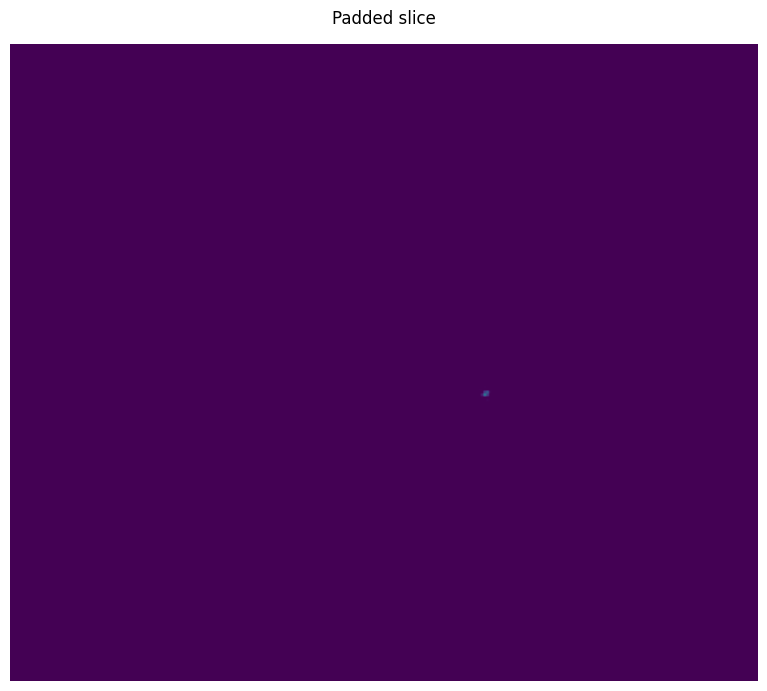

In [25]:
correct_rotation = True
autocrop = False

settings = VolumeSettings(
    orientation=Orientation.CORONAL,
    resolution=resolution,
    offset=40,
    pitch=30,
    yaw=50,
    shape=volume.shape,
)

expected_coordinates_from_volume_centre = [
    -settings.offset,
    centre_offset,
    centre_offset,
]

padded_slice_image = slice_image(
    volume, settings, autocrop=autocrop, correct_rotation=correct_rotation
)

image_centre = (np.array(padded_slice_image.shape) - 1) // 2

actual_coordinates_from_image_centre = (
    np.unravel_index(np.argmax(padded_slice_image), padded_slice_image.shape)
    - image_centre
)

imshow(padded_slice_image, title="Padded slice", figsize=(12, 7), vmin=0, vmax=500)

In [26]:
def apply_rotation(vector: list | np.ndarray, settings: VolumeSettings) -> np.ndarray:
    pitch = settings.pitch
    yaw = settings.yaw

    match settings.orientation:
        case Orientation.CORONAL:
            rotation = Rotation.from_euler("ZY", [pitch, yaw], degrees=True)
        case Orientation.HORIZONTAL:
            rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
        case Orientation.SAGITTAL:
            rotation = Rotation.from_euler("XY", [pitch, yaw], degrees=True)
        case other:
            # Should be impossible thanks to pydantic
            raise InvalidOrientationError(other)

    return rotation.apply(vector)

In [27]:
print(
    "Expected coordinates from volume centre: ", expected_coordinates_from_volume_centre
)
print("Actual coordinates from image centre:    ", actual_coordinates_from_image_centre)

print(
    "Corrected image coordinates to volume centre: ",
    apply_rotation([0, *actual_coordinates_from_image_centre], settings) + [-40, 0, 0],
)

Expected coordinates from volume centre:  [-40, 25, 25]
Actual coordinates from image centre:     [12 38]
Corrected image coordinates to volume centre:  [-20.79026997  24.94714926  24.42592917]


In [28]:
volume.shape

array([132,  80, 114])